In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Path indication to the loaded packages
import sys,os
#sys.path.insert(0, '/home/usr/Python_venv/lib/python3.8/site-packages/') 

In [4]:
os.environ["GRATIOSA_DB_PATH"]=os.getcwd()+"/../"

In [5]:
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import trapz
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from GRATIOSA import Genome, Chipseq, Transcriptome, GO 
from GRATIOSA import stat_analysis, plot_stat_analysis, useful_functions_Chipseq
from GRATIOSA.globvar import *
from scipy import stats
cm = 1/2.54  # centimeters in inches
outdir = resdir
import seaborn as sns
import csv

# 1 - Data importation and pre-processing

Genome objects initialization and sequencing loading as attribute

In [6]:
g = Genome.Genome("ecoli_W3110_Mu")
g.load_seq()
g.load_annotation()

Detected a genome with 1 chromosome
Chromosome NC_007779.1_w3110_Mu of length 4647454
Sequence of organism ecoli_W3110_Mu loaded
Trying to load annotation from: /home/s/topo_data/data/ecoli_W3110_Mu/annotation/sequence.gff3
Annotation of ecoli_W3110_Mu loaded
Number of genes: 4312


## A - Transcription Units positions and expressions

### TU loading

Loading of transcription units (TU) data present in the TU folder. Here, we will use the annotation and expression data published by Sutormin et al. 

In [7]:
g.load_TU()
allTUs = list(g.TUs["TUSutormin"].keys())

TUs loaded


Selection of TUs containing at least one stable RNAs

In [8]:
 #TUrtRNA: list of TUs with at least one stable RNA 
TUrtRNA = [126,  127,  133,  147,  243,  288,  329,  404,  405,  460,  461,
           488,  578,  773,  903,  935,  936,  939,  942, 1004, 1050, 1066,
           1071, 1164, 1165, 1205, 1266, 1267, 1285, 1347, 1391, 1431, 1432,
           1433, 1434, 1435, 1436, 1437, 1439, 1440, 1441, 1497, 1498, 1642,
           1699, 1700, 1757, 1758, 1783, 1784, 1808, 1809, 1863, 1864, 1865,
           1866, 1868, 1881, 1882, 1950, 1971, 2028, 2059, 2112, 2126, 2128,
           2137, 2139, 2140, 2142, 2145, 2152, 2157]
TUother = list(set(allTUs) - set(TUrtRNA))

# Classification of TU expression data based on the presence of stable RNA
TU_expr = {"rtRNA":{},"other":{}}
for ID, TU in g.TUs["TUSutormin"].items():
    if ID in TUrtRNA:
        TU_expr["rtRNA"][ID] = TU.expression
    else : 
        TU_expr["other"][ID] = TU.expression

### TU classification in expression classes

 TU classification according to their expression level with chosen class sizes
 * classif_TUs[0] is a dictionary containing the TU names for each class
 * classif_TUs[1] is a dictionary containing the expression values for each class
 * class_means is a dictionary containing the average expression of the TUs for each class

In [9]:
classif_TUs = stat_analysis.data_classification(
    data_x=TU_expr["other"].keys(),
    data_y=TU_expr["other"].values(),
    class_nb=5,
    class_names=["ME", 4, 3, 2, 1],
    class_sizes=[len(TUother)-800, 200, 200, 200, 200]
)

classif_TUs[0]["rtRNA"]=list(TU_expr["rtRNA"].keys())
classif_TUs[1]["rtRNA"]=list(TU_expr["rtRNA"].values())

class_means = {}
for exprclass in [1,2,3,4,"ME"]:
    class_means[exprclass] = np.mean([np.log2(x) for x in classif_TUs[1][exprclass] if x != 0])

ME: 1300 elements
4: 200 elements
3: 200 elements
2: 200 elements
1: 200 elements


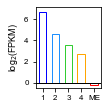

In [10]:
cat_colors = ["blue", "dodgerblue", "limegreen", "orange", "red"]
fig, ax = plt.subplots(figsize=(4*cm, 4*cm))
ax.bar([str(c) for c in class_means.keys()], class_means.values(),
       color='white', edgecolor=cat_colors, width=0.6, linewidth=1)
ax.set_ylim(-0.5, 7.2)
ax.set_ylabel("log$_2$(FPKM)")
ax.axhline(0, color="black", lw=1)
ax.set_yticks(np.arange(0, 8, 2))
plt.tight_layout()

TU classification in expression deciles
 * classif_TUs[0] is a dictionary containing the TU names for each class
 * classif_TUs[1] is a dictionary containing the expression values for each class

In [11]:
classif_deciles = stat_analysis.data_classification(
    data_x=TU_expr["other"].keys(),
    data_y=TU_expr["other"].values(),
    class_nb=10
)

classif_deciles[0]["rtRNA"]=list(TU_expr["rtRNA"].keys())
classif_deciles[1]["rtRNA"]=list(TU_expr["rtRNA"].values())

Performing the classification in the following classes:
0: from 0.0 to 0.2219460405665605
1: from 0.2228635134981604 to 0.5004320721857773
2: from 0.5006399528507197 to 0.983472590568697
3: from 0.9931627185897828 to 1.799746695169979
4: from 1.8003913626035322 to 3.0709541322556704
5: from 3.0768155202341028 to 4.984718475437905
6: from 4.993359039494553 to 8.103959961281214
7: from 8.105314740027312 to 15.844014036290488
8: from 15.868638890337257 to 37.766937523681115
9: from 37.952086050606454 to 1522.949849756477
0: 210 elements
1: 210 elements
2: 210 elements
3: 210 elements
4: 210 elements
5: 210 elements
6: 210 elements
7: 210 elements
8: 210 elements
9: 210 elements


### Conversion of expression data to an expression signal

In [12]:
# Create a dictionary to store expressions for each position
expr_pos = {p: [] for p in range(g.length)}

# Fill the dictionary with expressions
for ID, Tn in g.TUs["TUSutormin"].items():
    for p in np.arange(Tn.start, Tn.end):
        expr_pos[p].append(Tn.expression)

In [13]:
all_signals = {}
# Calculate the average expression for each position
expr_signal = [np.mean(expr_pos[p]) if len(expr_pos[p]) > 0 else 0 for p in range(g.length)]
all_signals['Expr'] = {"raw" : expr_signal[:g.length-1]}

# Calculate the min average expression level 
min_expr = min([e for e in expr_signal if e != 0])

# Calculate the log2 average expression for each position
log2expr_signal = [np.log2(e) if e != 0 else np.log2(min_expr) for e in expr_signal]
all_signals['log2Expr'] = {"raw" : log2expr_signal[:g.length-1]}

## B - Gyrase and topoI signals

Chipseq-type signals will be loaded as attributes of the Chipseq object.
This object must first be initialized.

In [13]:
ch = Chipseq.Chipseq(g)

### Loading and averaging of TopoI and Gyrase signal replicates

In [14]:
raw_smoothing = 500  # smoothing window size for the raw signal
cond = {"Topo" : ["Sutormin_TopoI_R1","Sutormin_TopoI_R2","Sutormin_TopoI_R3"],
        "Gyr" : ['Sutormin_Gyrase_R1', 'Sutormin_Gyrase_R2'], 
        "Topo_Rif" : ["Sutormin_TopoI_Rif_R1", "Sutormin_TopoI_Rif_R2", "Sutormin_TopoI_Rif_R3"],
        "Gyr_Rif" : ["Sutormin_CFX_Rif_Gyrase_R1", "Sutormin_CFX_Rif_Gyrase_R2", "Sutormin_CFX_Rif_Gyrase_R3"]
       } # replicates cond name

for styp in ["Topo","Gyr","Topo_Rif","Gyr_Rif"] : 
    all_signals[styp] = {}
    print(styp)
    # raw signal loading : performs the average between cond replicates and load this average as a Chipseq attribute
    ch.load_signals_average(list_cond=cond[styp],
                            average_name=f"{styp}_smooth{raw_smoothing}b",
                            data_treatment = "smoothing",
                            window=raw_smoothing)
    all_signals[styp]["raw"] = ch.signals_average[f"{styp}_smooth{raw_smoothing}b"][:g.length-1]

Topo
loading the file obtained with the following parameters:

Name: Topo_smooth500b

 Replicates: ['Sutormin_TopoI_R1', 'Sutormin_TopoI_R2', 'Sutormin_TopoI_R3']

 Data treatment: smoothing

 Size (window or bin, in b): 500

Please change 'average_name' to use other signals
Gyr
loading the file obtained with the following parameters:

Name: Gyr_smooth500b

 Replicates: ['Sutormin_Gyrase_R1', 'Sutormin_Gyrase_R2']

 Data treatment: smoothing

 Size (window or bin, in b): 500

Please change 'average_name' to use other signals
Topo_Rif
loading the file obtained with the following parameters:

Name: Topo_Rif_smooth500b

 Replicates: ['Sutormin_TopoI_Rif_R1', 'Sutormin_TopoI_Rif_R2', 'Sutormin_TopoI_Rif_R3']

 Data treatment: smoothing

 Size (window or bin, in b): 500

Please change 'average_name' to use other signals
Gyr_Rif
loading the file obtained with the following parameters:

Name: Gyr_Rif_smooth500b

 Replicates: ['Sutormin_CFX_Rif_Gyrase_R1', 'Sutormin_CFX_Rif_Gyrase_R2', 'Sutorm

### Loading of gyrase clivage sites and conversion as a signal

In [15]:
basedir

'/home/s/topo_data/'

In [16]:
GCS= []
with open(basedir+'data/ecoli_W3110_Mu/chipseq/sites/GCs_Cfx.csv', 'r') as f:
    file = csv.reader(f)
    next(file)
    for line in file:
        gcs = int(line[0])
        GCS.append(gcs)
signalGCS = np.zeros(g.length-1) # Initialize each genomic posiiton with the value 0
signalGCS[GCS] = 1  # Assign 1 to each gyrase clivage site genomic position
all_signals["GCS"]={"raw":signalGCS}

# 2 - Study at 2 scales : micro and macro 

## A - Macro signal settings choice
The macro signal is obtained in 2 steps:
* The raw signal is first averaged per bin of chosen size (set with the macro_bs parameter).
* The signal per bin is then smoothed by averaging over sliding windows of chosen sizes (set with the macro_add_smooth parameter).
The first step (binning) primarily serves to minimize the computation time required for smoothing (second step).

In [17]:
macro_bs = 100 # in b
macro_add_smooth = int(200000/macro_bs) # in b
study_ws = 50000 # the highest window size around the TU that will be use in this study (in b)

## B - Macro and micros signals computing

The micro signal is obtained by subtracting the macro signal from the raw signal.

In [18]:
for styp in ["Topo","Gyr","Expr","log2Expr","GCS","Topo_Rif","Gyr_Rif"] :
    #macro signal
    if styp in ["Topo","Gyr","Topo_Rif","Gyr_Rif"] : 
        ch.load_signals_average(list_cond=cond[styp],
                                average_name=f"{styp}_bin{macro_bs}b",
                                data_treatment = "binning",
                                binsize=macro_bs)
        binned_signal = ch.signals_average[f"{styp}_bin{macro_bs}b"]
        signal_per_bin = binned_signal[np.arange(0,len(binned_signal)+1,macro_bs)]
          
    else : 
        signal_per_bin = useful_functions_Chipseq.binning(all_signals[styp]["raw"],macro_bs)[0]
    
    macro_smoo_sign_per_bin = useful_functions_Chipseq.smoothing(signal_per_bin,macro_add_smooth)
    all_signals[styp]["macro"] = np.array(np.repeat(macro_smoo_sign_per_bin, macro_bs))[:g.length-1]
    
    #micro signal
    all_signals[styp]["micro"] = all_signals[styp]["raw"] - all_signals[styp]["macro"]

loading the file obtained with the following parameters:

Name: Topo_bin100b

 Replicates: ['Sutormin_TopoI_R1', 'Sutormin_TopoI_R2', 'Sutormin_TopoI_R3']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: Gyr_bin100b

 Replicates: ['Sutormin_Gyrase_R1', 'Sutormin_Gyrase_R2']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: Topo_Rif_bin100b

 Replicates: ['Sutormin_TopoI_Rif_R1', 'Sutormin_TopoI_Rif_R2', 'Sutormin_TopoI_Rif_R3']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: Gyr_Rif_bin100b

 Replicates: ['Sutormin_CFX_Rif_Gyrase_R1', 'Sutormin_CFX_Rif_Gyrase_R2', 'Sutormin_CFX_Rif_Gyrase_R3']

 Data treatment: bin

# C - Mean signal around the TU 
Compute the mean signal around the TU for each expression class, each signal type (TopoI, Gyr and Expr) and each scale (raw, micro and macro)

Careful: this operation is not numerically optimized and uses a lot of memory. May crash on a computer with insufficient memory.  

In [19]:
means_TU = {}
#total_TU = {}

for scale in ["micro","macro","raw"] :
    print(f"Working at {scale} scale...")
    means_TU[scale] = {}
    
    for styp in ["Gyr","Topo","Expr","log2Expr","Gyr_Rif","Topo_Rif"] : 
        print(f"... with {styp} signal")
        sign = all_signals[styp][scale]
        means_TU[scale][styp] = {}
        #if scale=="raw":
        #    total_TU[styp] = {}

        # Loop over each TU of each expression class
        for exprclass in classif_TUs[0].keys() :
            
            #if scale=="raw":
            #    total_TU[styp][exprclass] = {}
            
            interpolsignal = {}
            for ID in classif_TUs[0][exprclass] : 

                TU = g.TUs["TUSutormin"][ID]
                # Define the start and end of the window around the TU
                w_start = TU.start - study_ws
                w_end = TU.end + study_ws

                # Initialize a dictionary to store signals for each signal type ("Gyr" and "Topo")
                g_signals = {}

                # If the window extends beyond the start or end of the genome, wrap around to the other side
                if w_start < 0:
                    TUsignal = np.concatenate((sign[g.length + w_start - 1:],sign[:w_end]))
                elif w_end > g.length:
                    TUsignal = np.concatenate((sign[w_start:],sign[:w_end - g.length + 1]))
                else:
                    TUsignal = sign[w_start:w_end]

                # If the TU is on the negative strand, flip the signals
                if not TU.strand: 
                    TUsignal = np.flip(TUsignal)

                # Interpolate the signal within the window to 2000 points 
                inTU_sign = TUsignal[study_ws:-study_ws]
                f = interpolate.interp1d(np.arange(len(inTU_sign)), inTU_sign)           
                inTU_sign = f(np.linspace(0,len(inTU_sign)-1,num = 2000))   
                interpolsignal[ID] = np.concatenate((TUsignal[:study_ws], inTU_sign,TUsignal[-study_ws:]))
                
                #if scale=="raw":
                #    total_TU[styp][exprclass][ID] = np.concatenate((TUsignal[:study_ws], inTU_sign,TUsignal[-study_ws:]))
            
            df_sign = pd.DataFrame(interpolsignal)
            
            mean_sign = df_sign.mean(axis = 1)
            
            means_TU[scale][styp][exprclass] = {"all": mean_sign,
                                                "before": mean_sign[:study_ws],
                                                "after": mean_sign[-study_ws:]}
            

Working at micro scale...
... with Gyr signal
... with Topo signal
... with Expr signal
... with log2Expr signal
... with Gyr_Rif signal
... with Topo_Rif signal
Working at macro scale...
... with Gyr signal
... with Topo signal
... with Expr signal
... with log2Expr signal
... with Gyr_Rif signal
... with Topo_Rif signal
Working at raw scale...
... with Gyr signal
... with Topo signal
... with Expr signal
... with log2Expr signal
... with Gyr_Rif signal
... with Topo_Rif signal


# 3 - Stat analysis and graphical representations

## A - Graphic parameters

In [20]:
plt.rcParams.update({'font.size': 8,
                     'font.family': "Arial",
                     'xtick.labelsize': 8,
                     'ytick.labelsize': 8,
                     'axes.labelsize': 9,
                     'axes.titlesize': 10})
fig_ext = ".svg"

Define a list of colors and labels for the expression categories

In [21]:
classif_cats = ['rtRNA', 1, 2,3,4,'ME']
colors = ["black","blue", "dodgerblue", "limegreen", "orange","red"]
lme = len(classif_TUs[0]["ME"]) # get the number of TUs classified as "ME"
labels = ["rtRNA TUs","0 - 200 HETUs","200 - 400 HETUs",
          "400 - 600 HETUs","600 - 800 HETUs",f"Other TUs ({lme} TUs)"]
labels_short = ["rtRNA\nTUs","0 - 200\nHETUs","200 - 400\nHETUs",
                "400 - 600\nHETUs","600 - 800\nHETUs",f"Other TUs"]

Define a list of colors and labels for the signal types

In [22]:
styp_colors = {"Gyr" : "black", "GCS" : "black","Topo" : "darkgoldenrod","Expr" : "gray","log2Expr" : "gray" , "Gyr_Rif": "black", "Topo_Rif": "darkgoldenrod"}
styp_label = {"Gyr":"Gyrase","Topo":"Topoisomerase I","Expr":"FPKM","log2Expr":"log2(FPKM)", "Gyr_Rif": "Gyrase", "Topo_Rif": "Topoisomerase I"}

## B - Plot around the TU 

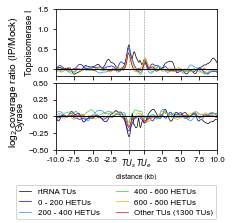

In [27]:
# Choose if we plot with or without rifampicin! comment the appropriate line
styps = ["Topo", "Gyr"]
#styps = ["Topo_Rif", "Gyr_Rif"]
# -------------------------------------

scale = "raw"

plot_ws =  10000 #window size for the plot, has to be less or equal to study_ws !

# Create a figure with 2 subplots (1 per signal type)
fig, ax = plt.subplots(2,1, figsize=(7.8*cm,7.5*cm))
fig.subplots_adjust(hspace=0.1, left=0.22, right=0.95, bottom=0.33, top=0.99)

# Create an array with indices for the x-axis
x = range(plot_ws*2+2000)
tick_interval = int(min([2500,5000,10000,20000], key=lambda x: abs(x - plot_ws/5)))
ticks_before = np.arange(0,int(plot_ws),tick_interval)
ticks_after = np.arange(plot_ws+2000+tick_interval,2*plot_ws+2000+tick_interval,tick_interval)

for p, styp in enumerate(styps):
    # Loop over the expression categories and plot their mean TU signals
    for ec, exprclass in enumerate(classif_cats):
        if -study_ws+plot_ws == 0 :
            ax[p].plot(x, means_TU[scale][styp][exprclass]["all"][study_ws-plot_ws:], label=labels[ec], c=colors[ec], lw=0.7)
        else : 
            ax[p].plot(x, means_TU[scale][styp][exprclass]["all"][study_ws-plot_ws:-study_ws+plot_ws], label=labels[ec], c=colors[ec], lw=0.7)
                
    # Add a horizontal line at y=0, a vertical line at the start of the TU,
    # and another one at the end of the TU
    ax[p].axhline(0, color='black', lw=1)
    ax[p].set_xlim(0, plot_ws*2+2000)
    ax[p].axvline(plot_ws, color='grey', ls='--', lw=0.5)
    ax[p].axvline(plot_ws+2000, color='grey', ls='--', lw=0.5)

# Set the axis and ticks labels
    ax[p].set_ylabel(styp_label[styp], fontsize=9)
    ax[p].set_xticks(np.concatenate((ticks_before,[plot_ws,plot_ws+2000],ticks_after)))

ax[1].set_xlabel("distance (kb)", fontsize=7)
ax[0].set_yticks(np.arange(0, 2, 0.5))
ax[1].set_yticks(np.arange(-0.5, 0.75, 0.25))
ax[0].set_xticklabels([])
ax[1].set_xticklabels(np.concatenate(((ticks_before-plot_ws)/1000,
                ['$TU_s$','$TU_e$'],
                (ticks_after-plot_ws-2000)/1000)))
fig.text(0.00, 0.65, 'log$_2$ coverage ratio (IP/Mock)', va='center', rotation='vertical',fontsize = 10)
            
# Set the legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels,handlelength=1.5,loc='lower center',ncol=2)

plt.savefig(f"{outdir}{scale}_signaux_{styps[0]}_{styps[1]}_{int(plot_ws/1000)}kb{fig_ext}",
            transparent=False,facecolor='white')

## C - Average signals per expression deciles in, before and after the TU

#### Compute TopoI and Gyrase mean signals per expression deciles

In [28]:
# Define the window size before and after the TU
ws = 10000
scale = "raw"
signal_per_exprclass = {}

for s in ["Gyr","Topo","log2Expr","Gyr_Rif","Topo_Rif"] : 
    
    # Initialize dictionary to store results by signal type ("Gyr" and "Topo")
    # and region relative to the TU ("before","in","after")
    signal_per_exprclass[s] = {}
    for pos in ["before","in","after"]:
        signal_per_exprclass[s][pos] = {}
        for i in classif_deciles[0].keys() : 
            signal_per_exprclass[s][pos][i] = []
            
    # Loop over each TU of each expression decile to compute the average signal for each 
    # signal type and each region
    for i in classif_deciles[0].keys() : 
        for ID in classif_deciles[0][i] :
            TU = g.TUs["TUSutormin"][ID]

            signal_per_exprclass[s]["in"][i].append(np.mean(all_signals[s][scale][TU.start:TU.end]))
            if TU.strand :
                signal_per_exprclass[s]["after"][i].append(np.mean(all_signals[s][scale][TU.end:TU.end+ws]))
                if ws <= TU.start : 
                    signal_per_exprclass[s]["before"][i].append(np.mean(all_signals[s][scale][TU.start-ws:TU.start]))
                # If the window extends beyond the start of the genome, wrap around to the other side
                elif ws > TU.start : 
                    diff = ws - TU.start
                    sign = np.concatenate([all_signals[s][scale][:TU.start],all_signals[s][scale][-diff:]])
                    signal_per_exprclass[s]["before"][i].append(np.mean(sign))

            else :
                signal_per_exprclass[s]["before"][i].append(np.mean(all_signals[s][scale][TU.end:TU.end+ws]))
                if ws <= TU.start : 
                    signal_per_exprclass[s]["after"][i].append(np.mean(all_signals[s][scale][TU.start-ws:TU.start]))
                # If the window extends beyond the start of the genome, wrap around to the other side
                elif ws > TU.start : 
                    diff = ws - TU.start
                    sign = np.concatenate([all_signals[s][scale][:TU.start],all_signals[s][scale][-diff:]])
                    signal_per_exprclass[s]["after"][i].append(np.mean(sign))

Expression values per expression deciles

In [29]:
signal_per_exprclass["expr"] = {}
signal_per_exprclass["expr"]["in"] = classif_deciles[1]

#### Student test to get all means and confidence intervals

In [30]:
res = {}
for s in ["Gyr","Topo","log2Expr","Gyr_Rif","Topo_Rif"] : 
    res[s] = {}
    for pos in signal_per_exprclass[s].keys():
        res[s][pos]=stat_analysis.quantitative_data_student_test(
            signal_per_exprclass[s][pos],
            output_dir=outdir,
            output_file=f"{s}_{scale}_{pos}_TU_exprdeciles")           

Results saved in /home/s/topo_data/resdir/Gyr_raw_before_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Gyr_raw_in_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Gyr_raw_after_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Topo_raw_before_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Topo_raw_in_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Topo_raw_after_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/log2Expr_raw_before_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/log2Expr_raw_in_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/log2Expr_raw_after_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Gyr_Rif_raw_before_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Gyr_Rif_raw_in_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Gyr_Rif_raw_after_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Topo_Rif_raw_before_TU_exprdeciles
Results saved in /home/s/topo_data/resdir/Topo_Ri

#### Graphical representation 
with one subplot for each location (before the TU, within the TU, and after the TU). The y-axis is discontinuous to highlight extreme values. The gyrase and topoI signals share the same axis, while the expression signal has its own axis.






[-3.3723105519934227, -2.908364615441885, -2.5582981180212485, -2.1751056676816045, -2.035416258480092, -2.0595591826014563, -2.34871452204409, -1.3661594679151432, -1.5924700030347143, -1.0526104880757, -1.0679594682411273]


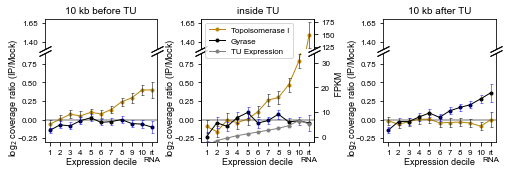

In [31]:
# Define categories and labels
expr_cats = res['Gyr']['before']['categories']
categories = ['before', 'in', 'after']
labels_cats = list(np.arange(1, 11)) + ['rt\nRNA']
legend_cats = [f'{int(ws/1000)} kb before TU', 'inside TU', f'{int(ws/1000)} kb after TU']
p = np.arange(len(expr_cats))

# Create subplots with 2 rows and 3 columns
fig, ax = plt.subplots(2, 3, figsize=(17.5/2.54, 2.5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
fig.subplots_adjust(hspace=0.06, wspace=0.5, left=0.07, right=0.98, bottom=0.20)

# Loop through subplots
for a in [0, 1]:
    for i, c in enumerate(categories):
        for styp, s in enumerate(["Topo", "Gyr"]):
            # Get means and confidence intervals
            means = res[s][c]['means']
            ci = np.zeros((2, len(expr_cats)))
            for ca in np.arange(len(expr_cats)):
                ci[0, ca] = means[ca] - res[s][c]["confidence intervals"][ca][0]
                ci[1, ca] = res[s][c]["confidence intervals"][ca][1] - means[ca]

            # Plot means with error bars
            ax[a, i].plot(p, means, '-o', label=styp_label[s], lw=1, markersize=3, color=styp_colors[s])
            ax[a, i].errorbar(p, means, yerr=ci, capsize=1.5, elinewidth=0.5, capthick=0.5, fmt="none", color=colors[styp])

        ax[0, i].set_title(legend_cats[i])
        ax[0, i].set_xticks(p)
        ax[0, i].set_ylim(1.3, 1.7)
        ax[1, i].set_ylim(-0.3, 0.9)

        # Hide spines between ax and ax2
        ax[0, i].spines.bottom.set_visible(False)
        ax[1, i].spines.top.set_visible(False)
        ax[a, i].tick_params(labeltop=False)  
        ax[a, i].xaxis.tick_bottom()
        ax[0, i].tick_params(axis='x', colors='white')      
       
        d = .5 
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax[0, i].plot([0, 1], [0, 0], transform=ax[0, i].transAxes, **kwargs)
        ax[1, i].plot([0, 1], [1, 1], transform=ax[1, i].transAxes, **kwargs)

        # Set labels and ticks
        ax[1, i].set_xlabel('Expression decile', labelpad=-5)
        ax[0, i].set_xticklabels(labels_cats)
        ax[1, i].set_yticks(np.arange(-0.25, 1, 0.25))
        ax[0, i].set_yticks(np.arange(1.4, 1.7, 0.25))
        ax[1, i].set_ylabel("log$_2$ coverage ratio (IP/Mock)", labelpad=-3)
        
        
        ax[1, i].axhline(y=0, lw=0.3, c="black")

# Extract mean expression data
means = res['log2Expr']['in']['means']
ci = np.zeros((2, len(expr_cats)))

for ca in np.arange(len(expr_cats) - 1):
    ci[0, ca] = means[ca] - res['log2Expr']['in']["confidence intervals"][ca][0]
    ci[1, ca] = res['log2Expr']['in']["confidence intervals"][ca][1] - means[ca]

# Create twin axes to plot TU Expression data
axbis = ax[1, 1].twinx()
axbis.spines.bottom.set_visible(False)
axbis.spines.top.set_visible(False)        
axbis.plot(res['log2Expr']['in']['means'], '-o', label='TU Expression', lw=1, color=styp_colors["Expr"], markersize=3)
axbis.set_ylim(-2, 34)
axbis.errorbar(p, means, yerr=ci, ecolor=styp_colors["Expr"], capsize=1.5, elinewidth=0.5, capthick=0.5, fmt="none")
axbis.set_ylabel(f'           FPKM', labelpad=5)

axhaut = ax[0, 1].twinx()
axhaut.spines.bottom.set_visible(False)
axhaut.spines.top.set_visible(False)        
axhaut.plot(p[:-1], means[:-1], '-o', label='TU Expression', lw=1, color="gray", markersize=3)
axhaut.set_ylim(120, 180)
axhaut.errorbar(p, means, yerr=ci, ecolor="gray", capsize=1.5, elinewidth=0.5, capthick=0.5, fmt="none")

# Add legends to the plots
lines1, labels1 = ax[0, 0].get_legend_handles_labels()
lines2, labels2 = axhaut.get_legend_handles_labels()
axhaut.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust the position of the subplot in the second column
for a in [0, 1]:
    pos1 = ax[a, 1].get_position()
    pos1_new = [pos1.x0 - 0.025, pos1.y0, pos1.width, pos1.height] 
    ax[a, 1].set_position(pos1_new)
    
print(res['log2Expr']['before']['means'])
    
# Save the figure 
plt.savefig(f"{outdir}{scale}_signals_TUdeciles_{int(ws/1000)}kb{fig_ext}", transparent=True, facecolor='white')


[-3.3723105519934227, -2.908364615441885, -2.5582981180212485, -2.1751056676816045, -2.035416258480092, -2.0595591826014563, -2.34871452204409, -1.3661594679151432, -1.5924700030347143, -1.0526104880757, -1.0679594682411273]


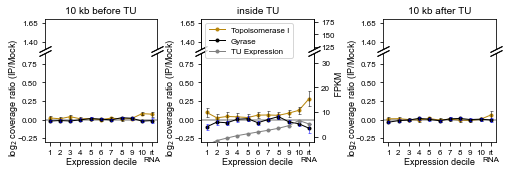

In [32]:
# SAME WITH RIFAMPICIN!!

# Create subplots with 2 rows and 3 columns
fig, ax = plt.subplots(2, 3, figsize=(17.5/2.54, 2.5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
fig.subplots_adjust(hspace=0.06, wspace=0.5, left=0.07, right=0.98, bottom=0.20)

# Loop through subplots
for a in [0, 1]:
    for i, c in enumerate(categories):
        for styp, s in enumerate(["Topo_Rif", "Gyr_Rif"]):
            # Get means and confidence intervals
            means = res[s][c]['means']
            ci = np.zeros((2, len(expr_cats)))
            for ca in np.arange(len(expr_cats)):
                ci[0, ca] = means[ca] - res[s][c]["confidence intervals"][ca][0]
                ci[1, ca] = res[s][c]["confidence intervals"][ca][1] - means[ca]

            # Plot means with error bars
            ax[a, i].plot(p, means, '-o', label=styp_label[s], lw=1, markersize=3, color=styp_colors[s])
            ax[a, i].errorbar(p, means, yerr=ci, capsize=1.5, elinewidth=0.5, capthick=0.5, fmt="none", color=colors[styp])

        ax[0, i].set_title(legend_cats[i])
        ax[0, i].set_xticks(p)
        ax[0, i].set_ylim(1.3, 1.7)
        ax[1, i].set_ylim(-0.3, 0.9)

        # Hide spines between ax and ax2
        ax[0, i].spines.bottom.set_visible(False)
        ax[1, i].spines.top.set_visible(False)
        ax[a, i].tick_params(labeltop=False)  
        ax[a, i].xaxis.tick_bottom()
        ax[0, i].tick_params(axis='x', colors='white')      
       
        d = .5 
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax[0, i].plot([0, 1], [0, 0], transform=ax[0, i].transAxes, **kwargs)
        ax[1, i].plot([0, 1], [1, 1], transform=ax[1, i].transAxes, **kwargs)

        # Set labels and ticks
        ax[1, i].set_xlabel('Expression decile', labelpad=-5)
        ax[0, i].set_xticklabels(labels_cats)
        ax[1, i].set_yticks(np.arange(-0.25, 1, 0.25))
        ax[0, i].set_yticks(np.arange(1.4, 1.7, 0.25))
        ax[1, i].set_ylabel("log$_2$ coverage ratio (IP/Mock)", labelpad=-3)
        
        
        ax[1, i].axhline(y=0, lw=0.3, c="black")

# Extract mean expression data
means = res['log2Expr']['in']['means']
ci = np.zeros((2, len(expr_cats)))

for ca in np.arange(len(expr_cats) - 1):
    ci[0, ca] = means[ca] - res['log2Expr']['in']["confidence intervals"][ca][0]
    ci[1, ca] = res['log2Expr']['in']["confidence intervals"][ca][1] - means[ca]

# Create twin axes to plot TU Expression data
axbis = ax[1, 1].twinx()
axbis.spines.bottom.set_visible(False)
axbis.spines.top.set_visible(False)        
axbis.plot(res['log2Expr']['in']['means'], '-o', label='TU Expression', lw=1, color=styp_colors["Expr"], markersize=3)
axbis.set_ylim(-2, 34)
axbis.errorbar(p, means, yerr=ci, ecolor=styp_colors["Expr"], capsize=1.5, elinewidth=0.5, capthick=0.5, fmt="none")
axbis.set_ylabel(f'           FPKM', labelpad=5)

axhaut = ax[0, 1].twinx()
axhaut.spines.bottom.set_visible(False)
axhaut.spines.top.set_visible(False)        
axhaut.plot(p[:-1], means[:-1], '-o', label='TU Expression', lw=1, color="gray", markersize=3)
axhaut.set_ylim(120, 180)
axhaut.errorbar(p, means, yerr=ci, ecolor="gray", capsize=1.5, elinewidth=0.5, capthick=0.5, fmt="none")

# Add legends to the plots
lines1, labels1 = ax[0, 0].get_legend_handles_labels()
lines2, labels2 = axhaut.get_legend_handles_labels()
axhaut.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust the position of the subplot in the second column
for a in [0, 1]:
    pos1 = ax[a, 1].get_position()
    pos1_new = [pos1.x0 - 0.025, pos1.y0, pos1.width, pos1.height] 
    ax[a, 1].set_position(pos1_new)
    
print(res['log2Expr']['before']['means'])
    
# Save the figure 
plt.savefig(f"{outdir}{scale}_signals_Rif_TUdeciles_{int(ws/1000)}kb{fig_ext}", transparent=True, facecolor='white')


In [109]:
res["Expr"]

{'before': {'categories': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'rtRNA'],
  'means': [8.005099914497645,
   277.2037223165345,
   249.37751848099208,
   345.8912351382709,
   347.9101765673679,
   253.5718641676268,
   101.11573772441386,
   366.1140717790469,
   333.49455481013695,
   179.71818386203233,
   1093.8328844268142],
  'confidence intervals': [(2.22218303486439, 13.7880167941309),
   (37.69636333101096, 516.711081302058),
   (20.784832588285155, 477.970204373699),
   (51.188224879591985, 640.5942453969498),
   (71.70622767437231, 624.1141254603635),
   (14.716893201857488, 492.42683513339614),
   (-30.85202967801237, 233.0835051268401),
   (66.42939848344344, 665.7987450746505),
   (61.45781283218872, 605.5312967880852),
   (26.440991838297833, 332.99537588576686),
   (368.04426275607136, 1819.621506097557)],
  'p-values': {(0, 1): 0.014094901637492403,
   (0, 2): 0.019585966043571577,
   (0, 3): 0.012589345907567877,
   (0, 4): 0.008159455385613575,
   (0, 5): 0.02230123896101596

## D - Autocorrelation and correlations

In [33]:
study_signals = {"log2Expr":all_signals["log2Expr"]['raw'],"Gyr" : all_signals["Gyr"]['raw'], "Topo" : all_signals["Topo"]['raw'], "Gyr_Rif" : all_signals["Gyr_Rif"]['raw'], "Topo_Rif" : all_signals["Topo_Rif"]['raw']}

### autocorrelation

Compute the pearson coefficient for the correlation between a signal and itself shifted 

In [34]:
num=100
p,d = {},{}
for label, signal in study_signals.items():
    p[label] = []
    d[label] = []
    for a in np.logspace(2, 6, num=num,endpoint=True, base=10.0, dtype=int, axis=0) : 
        d[label].append(a/1000)
        signal_d = np.concatenate((signal[-a:],signal[:-a]))
        pear = stats.pearsonr(signal,signal_d)
        p[label].append(pear[0])

### correlation

For an increasing smoothing window size, compute the pearson coefficient for the correlation between Gyr or TopoI signal and the log2Expr signal. 
To perform an efficient smoothing, the signal is binned prior to the smoothing. 

In [35]:
binsize = 100
bin_signals = {}

for styp in ["Topo","Gyr","Topo_Rif","Gyr_Rif"]: 
    ch.load_signals_average(list_cond=cond[styp],
                            average_name=f"{styp}_bin{binsize}b",
                            data_treatment = "binning",
                            binsize=binsize)
    binned_signal = ch.signals_average[f"{styp}_bin{binsize}b"]
    bin_signals[styp]= binned_signal[np.arange(0,len(binned_signal),binsize)]

process_signal = useful_functions_Chipseq.binning(log2expr_signal,binsize)
bin_signals["log2Expr"] = process_signal[0]

loading the file obtained with the following parameters:

Name: Topo_bin100b

 Replicates: ['Sutormin_TopoI_R1', 'Sutormin_TopoI_R2', 'Sutormin_TopoI_R3']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: Gyr_bin100b

 Replicates: ['Sutormin_Gyrase_R1', 'Sutormin_Gyrase_R2']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: Topo_Rif_bin100b

 Replicates: ['Sutormin_TopoI_Rif_R1', 'Sutormin_TopoI_Rif_R2', 'Sutormin_TopoI_Rif_R3']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals
loading the file obtained with the following parameters:

Name: Gyr_Rif_bin100b

 Replicates: ['Sutormin_CFX_Rif_Gyrase_R1', 'Sutormin_CFX_Rif_Gyrase_R2', 'Sutormin_CFX_Rif_Gyrase_R3']

 Data treatment: bin

In [36]:
num=100
pearson_coef = {"Topo":{},"Gyr":{},"Topo_Rif":{},"Gyr_Rif":{}}

for i in np.logspace(0, 4, num=num, endpoint=True, base=10.0, dtype=int, axis=0) : 
    
    smoo_Expr = useful_functions_Chipseq.smoothing(bin_signals['log2Expr'],i)
    
    for styp in ["Topo","Gyr","Topo_Rif","Gyr_Rif"]:         
        smoo_sign = useful_functions_Chipseq.smoothing(bin_signals[styp],i) 
        pearson_coef[styp][i*binsize]= stats.pearsonr(smoo_sign,smoo_Expr)[0]

#### Graphical representation

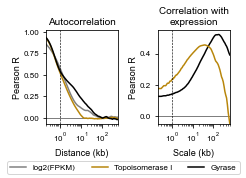

In [43]:
# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(7.8*cm, 6*cm))
fig.subplots_adjust(hspace=0.06, wspace=0.55, bottom=0.3, right=0.98, top=0.85, left=0.15)

# Add a horizontal line at y=0 in both subplots
for i in [0, 1]:
    axs[i].axhline(y=0, c='black', lw=0.5)

smoo_p = {}
for styp in ["log2Expr","Topo","Gyr"]:
    # Smooth and plot the autocorrelation pearson coefficients data
    smoo_p[styp] = useful_functions_Chipseq.smoothing(p[styp], 6)
    axs[0].plot(d[styp], smoo_p[styp], color=styp_colors[styp], label=styp_label[styp])

# Set labels and titles for the autocorrelation subplot
axs[0].set_xlabel('Distance (kb)')
axs[0].set_title('Autocorrelation')

# Plot Pearson correlation coefficients in the second subplot
for styp in ["Gyr", "Topo"]:
    axs[1].plot([k/1000 for k in pearson_coef[styp].keys()], [x for x in pearson_coef[styp].values()], color=styp_colors[styp])

# Set x-axis scale to logarithmic, limits, and labels
for i in [0, 1]:
    axs[i].set_xscale("log")
    axs[i].set_xlim(0.2, 600)
    axs[i].set_ylabel('Pearson R', labelpad=1)
    axs[i].axvline(x=1, c='black', lw=0.6, ls='--')

# Set specific y-axis limits for the second subplot
axs[1].set_ylim(-0.05, 0.55)

# Set x-axis label, title, and legend for the second subplot
axs[1].set_xlabel('Scale (kb)')
axs[1].set_title('Correlation with\nexpression')
fig.legend(loc='lower center', ncol=3)

# Save the figure
plt.savefig(f"{outdir}correlations_autocorrel_{num}points{fig_ext}", transparent=False, facecolor='white')


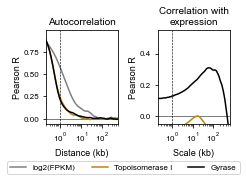

In [44]:
# SAME WITH RIFAMPICIN !!

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(7.8*cm, 6*cm))
fig.subplots_adjust(hspace=0.06, wspace=0.55, bottom=0.3, right=0.98, top=0.85, left=0.15)

# Add a horizontal line at y=0 in both subplots
for i in [0, 1]:
    axs[i].axhline(y=0, c='black', lw=0.5)

smoo_p = {}
for styp in ["log2Expr","Topo_Rif","Gyr_Rif"]:
    # Smooth and plot the autocorrelation pearson coefficients data
    smoo_p[styp] = useful_functions_Chipseq.smoothing(p[styp], 6)
    axs[0].plot(d[styp], smoo_p[styp], color=styp_colors[styp], label=styp_label[styp])

# Set labels and titles for the autocorrelation subplot
axs[0].set_xlabel('Distance (kb)')
axs[0].set_title('Autocorrelation')

# Plot Pearson correlation coefficients in the second subplot
for styp in ["Gyr_Rif", "Topo_Rif"]:
    axs[1].plot([k/1000 for k in pearson_coef[styp].keys()], [x for x in pearson_coef[styp].values()], color=styp_colors[styp])

# Set x-axis scale to logarithmic, limits, and labels
for i in [0, 1]:
    axs[i].set_xscale("log")
    axs[i].set_xlim(0.2, 600)
    axs[i].set_ylabel('Pearson R', labelpad=1)
    axs[i].axvline(x=1, c='black', lw=0.6, ls='--')

# Set specific y-axis limits for the second subplot
axs[1].set_ylim(-0.05, 0.55)

# Set x-axis label, title, and legend for the second subplot
axs[1].set_xlabel('Scale (kb)')
axs[1].set_title('Correlation with\nexpression')
fig.legend(loc='lower center', ncol=3)

# Save the figure
plt.savefig(f"{outdir}correlations_Rif_autocorrel_{num}points{fig_ext}", transparent=False, facecolor='white')


## E - Study at micro scale : cumulative signal around the TU 

The cumulative signal corresponds to the area under the curve (i.e., under the signal) up to the distance chosen with the study_ws parameter.

To compute it, it is necessary to:
* Calculate the average signal over the distance before the TU ("mb") and after the TU ("ma").
* Calculate the area under these signals using the trapezoidal method.

In [39]:
study_ws = 50000 #(in b) 
cumul_sign = {}

for scale in ["micro","macro","raw"] :
    print(f"Working at {scale} scale...")
    cumul_sign[scale] = {}
    
    for styp in ["Gyr","Topo","Expr","log2Expr","Gyr_Rif","Topo_Rif"] : 
        print(f"... with {styp} signal")
        cumul_sign[scale][styp] = {}
        
        for c,exprclass in enumerate(classif_cats) :
            cumul_sign[scale][styp][exprclass]  = {"before":[],"after":[]} 
            mb = np.flip(means_TU[scale][styp][exprclass]["before"]) 
            ma = means_TU[scale][styp][exprclass]["after"]
    
            for i in np.arange(0,study_ws,100) :
                cumul_sign[scale][styp][exprclass]["before"].append(trapz(mb.iloc[:i+1], np.arange(i+1)))
                cumul_sign[scale][styp][exprclass]["after"].append(trapz(ma.iloc[:i+1], np.arange(i+1)))

Working at micro scale...
... with Gyr signal
... with Topo signal
... with Expr signal
... with log2Expr signal
... with Gyr_Rif signal
... with Topo_Rif signal
Working at macro scale...
... with Gyr signal
... with Topo signal
... with Expr signal
... with log2Expr signal
... with Gyr_Rif signal
... with Topo_Rif signal
Working at raw scale...
... with Gyr signal
... with Topo signal
... with Expr signal
... with log2Expr signal
... with Gyr_Rif signal
... with Topo_Rif signal


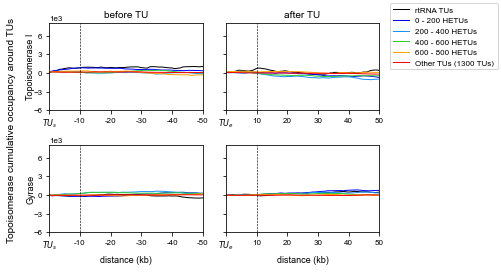

In [40]:
# Define the types of signals to be plotted and the scale (e.g., "micro") for signal analysis
# Choose between with and without rifampicin by commenting the appropriate line! 
#styps = ['Topo', 'Gyr']
styps = ['Topo_Rif', 'Gyr_Rif']
# -------------------------------------


scale = "micro"

# Set the window size (in b) for the plot, ensuring it's less than or equal to the study_ws
plot_ws = 50000

# Create a subplot with 2 rows and 2 columns, sharing the y-axis
f, axs = plt.subplots(2, 2, figsize=(17.5 * cm, 9 * cm), sharey=True)

# Adjust the spacing and margins between subplots
f.subplots_adjust(hspace=0.4, wspace=0.15, left=0.095, right=0.76, bottom=0.1, top=0.92)

# Loop through the signal types (styps) and classification categories (exprclass)
for n, styp in enumerate(styps):
    for c, exprclass in enumerate(classif_cats):
        # Determine whether it's the first signal type (styp) to set labels
        if n == 0:
            axs[n, 0].plot(np.arange(0, plot_ws, 100), cumul_sign[scale][styp][exprclass]["before"], c=colors[c], lw=1)
        else:
            axs[n, 0].plot(np.arange(0, plot_ws, 100), cumul_sign[scale][styp][exprclass]["before"],
                           label=labels[c], c=colors[c], lw=1)
        
        # Plot the signal "after" the specified distance
        axs[n, 1].plot(np.arange(0, plot_ws, 100), cumul_sign[scale][styp][exprclass]["after"], c=colors[c], lw=1)
        
        # Set the y-axis label based on the signal type (styp)
        axs[n, 0].set_ylabel(styp_label[styp], labelpad=-2)

    # Configure the x and y-axis properties for the subplots
    for i in [0, 1]:
        axs[n, i].set_xlim(0, plot_ws)
        axs[n, i].ticklabel_format(style='sci', axis='y', scilimits=(3, 3))
        axs[n, i].set_xticks(np.arange(0, plot_ws + 10, 10000))
        axs[n, i].set_yticks(np.arange(-6000, 13000, 3000))
        axs[n, i].set_ylim(-6000, 8000)
        axs[n, i].axvline(10 * 1000, c="black", ls="--", lw=0.6)
    axs[n, 0].set_xticklabels(np.concatenate((['$TU_{s}$'], np.flip(np.arange(int(-plot_ws/1000), 0, 10)))))
    axs[n, 1].set_xticklabels(np.concatenate((['$TU_{e}$'], np.arange(10, int(plot_ws/1000) + 10, 10))))

# Set subplot axis labels and titles  
axs[1, 0].set_xlabel("distance (kb)")
axs[1, 1].set_xlabel("distance (kb)")
axs[0, 0].set_title(f'before TU')
axs[0, 1].set_title(f'after TU')
f.text(0.01, 0.5, 'Topoisomerase cumulative occupancy around TUs', va='center', rotation='vertical', fontsize=10)

# Add a legend to the figure
f.legend(loc='upper right', ncol=1)

# Save the figure
plt.savefig(f"{outdir}{scale}_cumulative_signals_{styps[0]}_{styps[1]}_{int(plot_ws/1000)}kb{fig_ext}",
            transparent=False, facecolor='white')

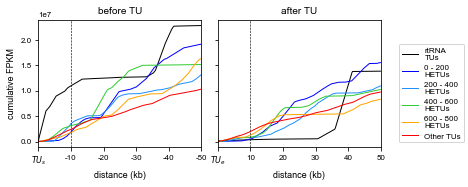

In [38]:
#same plot for the expression signal
styp = "Expr"
scale = "raw"
plot_ws = 50000 

f, axs = plt.subplots(1, 2, figsize=(17.5*cm,6*cm),sharey=True)
f.subplots_adjust(hspace=0.3,wspace=0.1,left=0.14, right=0.83,bottom=0.15,top = 0.9)

for c, exprclass in enumerate(classif_cats):
    mb = np.flip(means_TU[scale][styp][exprclass]["before"])
    ma = means_TU[scale][styp][exprclass]["after"]
    
    cumul_sign[scale][styp][exprclass] = {"before":[],"after":[]} 
    for i in np.arange(0,plot_ws,100) :
        cumul_sign[scale][styp][exprclass]["before"].append(trapz(mb.iloc[:i+1], np.arange(i+1)))
        cumul_sign[scale][styp][exprclass]["after"].append(trapz(ma.iloc[:i+1], np.arange(i+1)))
    axs[0].plot(np.arange(0,plot_ws,100),cumul_sign[scale][styp][exprclass]["before"],label = labels_short[c],c=colors[c],lw=1)
    axs[1].plot(np.arange(0,plot_ws,100),cumul_sign[scale][styp][exprclass]["after"],c=colors[c],lw=1)
        
for i in [0,1]:
    axs[i].set_xlim(0,plot_ws)
    axs[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[i].set_xticks(np.arange(0,plot_ws+10,10000))
    axs[i].axvline(10*1000,c="black",ls="--",lw=0.6)
axs[0].set_xticklabels(np.concatenate((['$TU_{s}$'],np.flip(np.arange(int(-plot_ws/1000),0,10)))))  
axs[1].set_xticklabels(np.concatenate((['$TU_{e}$'],np.arange(10,int(plot_ws/1000)+10,10)))) 

axs[0].set_ylabel("cumulative FPKM")
axs[0].set_xlabel("distance (kb)")
axs[1].set_xlabel("distance (kb)")
axs[0].set_title(f'before TU',fontsize=10)
axs[1].set_title(f'after TU',fontsize=10)

f.legend(loc='center right')

plt.savefig(f"{outdir}{styp}_{scale}_cumulatif_plot_ws{int(plot_ws/1000)}kb{fig_ext}",
            transparent=False,facecolor='white')

## E - Violin plot of the distribution

The purpose of this step is to study the average signal per bin of a chosen size specified by the bin_scale parameter in order to compare macro and micro signals. It is also of interest to compare the distribution of these signals per bin with the average signal values over the same distance (bin_scale) after and before the transcription units (TUs) based on their expression levels.

In [41]:
bin_scale = 50000 # in b
styps = ["Topo","Gyr","Topo_Rif","Gyr_Rif"]

binned_sign = {}
mean_aroundTU_binscale = {}

for styp in styps :
    binned_sign[styp] = {}
    mean_aroundTU_binscale[styp] = {}
    
    for scale in ["micro","macro"] :   
        # compute the mean signal in each bin of bin_scale size 
        binned_sign[styp][scale] = useful_functions_Chipseq.binning(all_signals[styp][scale],bin_scale)[0]
        
        # compute the mean signal in the bin before and in the bin after the TU
        mean_aroundTU_binscale[styp][scale] = {}
        for ec in classif_cats :
            mean_aroundTU_binscale[styp][scale][ec] = {"before":cumul_sign[scale][styp][ec]["before"][int(bin_scale/100)-1],
                                                       "after":cumul_sign[scale][styp][ec]["after"][int(bin_scale/100)-1]}

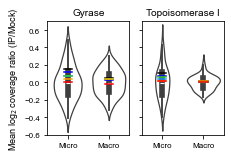

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(7.8*cm, 5*cm),sharey=True)
plt.subplots_adjust(top=0.9,wspace=0.15,bottom=0.1,right=0.98,left=0.18) 

styps = ["Gyr","Topo"]
for i, styp in enumerate(styps):
    sns.violinplot(data=[binned_sign[styp]["micro"],binned_sign[styp]["macro"]], ax=axs[i],color='white')
    axs[i].set_title(styp_label[styp])  
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['Micro', 'Macro'])
    axs[i].set_ylim(-.6,.7)
axs[0].set_ylabel(f"Mean log$_2$ coverage ratio (IP/Mock)")

lines_list = []
for sc, scale in enumerate(["micro","macro"]) : 
    for c, exprclass in enumerate(classif_cats) : 
        for n,styp in enumerate(styps) : 
            if styp == "Gyr" :
                pos = mean_aroundTU_binscale[styp][scale][exprclass]["after"]/bin_scale
            else : 
                pos = mean_aroundTU_binscale[styp][scale][exprclass]["before"]/bin_scale
            line = lines.Line2D((sc-0.1, sc+0.1), (pos,pos), color = colors[c],label=labels[c])
            axs[n].add_artist(line)

plt.savefig(f"{outdir}distrib_violinplot_{int(bin_scale/1000)}kb{fig_ext}",
                            transparent=False,facecolor='white')

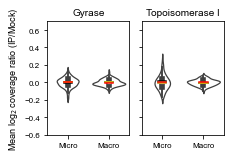

In [52]:
# SAME WITH RIFAMPICIN !!

fig, axs = plt.subplots(1, 2, figsize=(7.8*cm, 5*cm),sharey=True)
plt.subplots_adjust(top=0.9,wspace=0.15,bottom=0.1,right=0.98,left=0.18) 

styps = ["Gyr_Rif","Topo_Rif"]
for i, styp in enumerate(styps):
    sns.violinplot(data=[binned_sign[styp]["micro"],binned_sign[styp]["macro"]], ax=axs[i],color='white')
    axs[i].set_title(styp_label[styp])  
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['Micro', 'Macro'])   
    axs[i].set_ylim(-.6,.7)
axs[0].set_ylabel(f"Mean log$_2$ coverage ratio (IP/Mock)")

lines_list = []
for sc, scale in enumerate(["micro","macro"]) : 
    for c, exprclass in enumerate(classif_cats) : 
        for n,styp in enumerate(styps) : 
            if styp == "Gyr" :
                pos = mean_aroundTU_binscale[styp][scale][exprclass]["after"]/bin_scale
            else : 
                pos = mean_aroundTU_binscale[styp][scale][exprclass]["before"]/bin_scale
            line = lines.Line2D((sc-0.1, sc+0.1), (pos,pos), color = colors[c],label=labels[c])
            axs[n].add_artist(line)

plt.savefig(f"{outdir}distrib_violinplot_Rif_{int(bin_scale/1000)}kb{fig_ext}",
                            transparent=False,facecolor='white')

## G - Study at macro scale : genomic distribution of the signals

In [41]:
# positions of the detected borders bins between two CIDs.
CID= [8, 29, 44, 88, 102, 152, 196, 229, 239, 260, 317, 334, 359, 369, 420, 451, 476, 505, 544, 579, 598, 633,
659, 686, 729, 760, 787, 806, 832, 841, 893]
for n,c in enumerate(CID) :
    if c*5 > 3423 and c*5 < 4214 :  #genomic inversion between E. coli W3110 and E. coli MG1655
        CID[n] = (3424+(4214-c*5))/5
noCID = [N for N in range(930) if N not in CID]

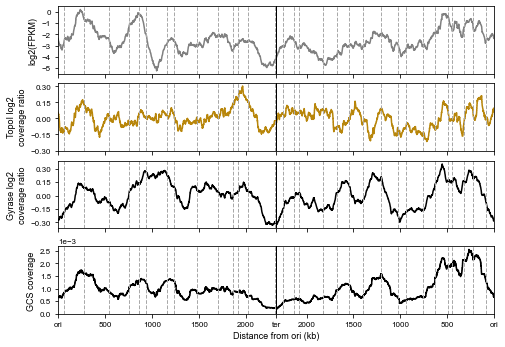

In [42]:
ori = 3925859
ter = int(4647500/2)

titles = ["log2(FPKM)","TopoI log2\ncoverage ratio","Gyrase log2\ncoverage ratio","GCS coverage"]
fig, ax = plt.subplots(4,1, figsize=(17.5*cm,12*cm), constrained_layout=True,sharex=True)


for n,styp in enumerate(["log2Expr","Topo","Gyr","GCS"]):
    sign = all_signals[styp]["macro"]
    ax[n].plot(np.concatenate((sign[ori:],sign[:ori])),color = styp_colors[styp])
    ax[n].set_ylabel(titles[n])
    ax[n].axvline(x=ter,lw = 1,color="black")
    if styp in ["Gyr","Topo"]:
        ax[n].set_yticks(np.arange(-0.3,0.4,0.15))
    elif styp == "log2Expr" :
        ax[n].set_yticks(np.arange(-5,1,1))
    elif styp == "GCS" :
        ax[n].set_yticks(np.arange(0,0.003,0.0005))
        ax[n].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for i in np.arange(4) : 
    for cid in CID : 
        if cid*5000 < ori :
            ax[i].axvline(x=cid*5000+4647500-ori, color = 'darkgray',lw=1,ls="--")
        elif cid*5000 > ori : 
            ax[i].axvline(x=cid*5000-ori, color = 'darkgray', lw=1,ls="--")

right_rep = np.arange(0,ter,int(500000))
left_rep = [len(all_signals[styp]["macro"]) - x for x in np.arange(0,ter,int(500000))][::-1]
ax[3].set_xticks(np.concatenate([right_rep,[ter],left_rep]))

lab = np.arange(500,int(ter/1000),500)
ax[3].set_xticklabels(np.concatenate([["ori"],lab,["ter"],lab[::-1],["ori"]]))

plt.xlim(0,len(all_signals[styp]["macro"]))   
plt.xlabel('Distance from ori (kb)')

plt.savefig(f"{outdir}MacroGyrTopoExpr_genome_ bin{macro_bs}b_smoothing_{int(macro_add_smooth)}_bins_CIDs.svg",
                        transparent=False,facecolor='white')